## IBM Q X 14-qubit device:
### Scalable characterization of all local-averaged Pauli error rates

© Robin Harper 2016-2020

Best viewed with the nbextensions, Collapsible Headings enabled.

<span style="color:blue">
The purpose of this notebook is to analyze data from the IBM 14-qubit quantum device (Melbourne) taken using the scalable noise reconstruction protocol for estimating averaged Pauli error rates. The full protocol for estimating all of the Pauli error rates requires the ability to generate a 14-qubit Clifford gate, and this is too ambitious for this device. Therefore, we focus on the simpler task of estimating the _symmetrized_ error rates, where we twirl with $n$ copies of the single-qubit Clifford group/twin-qubit Clifford group instead of the Pauli group. </span>

    
In this worksheet we won't produce error bars. To see how we use bootstrapping to do this, checkout the SingleQubitProtocol worksheet.


-----------------

## For the two qubit protocol use the workbook TwoQubitGates

------------------

© Robin Harper 2015-2020

# Load in the software we are using


1. We use a few standard Julia packages, which will need to be added if you don't have them.

 - LsqFit
 - Hadamard
 - PyPlot
 - ProgressMeter

2. Define a couple of convenience functions.


In [1]:
using LsqFit
using Hadamard
using PyPlot
using ProgressMeter
using Juqst
# convenience (type /otimes<tab>)
⊗ = kron

kron (generic function with 34 methods)

In [2]:
# A lot of the drawing stuff is particular to the IBM 14 qubit machine
# and is in a seperate file
include("./marginalDrawing.jl")

covhinton

In [3]:
# The fitting model, for use with LsqFit.
modelF(x, p) = p[1]*(p[2].^x)

modelF (generic function with 1 method)

# Load in the single qubit twirl data

 - read in the files
 - transform and fit, extracting the fit parameter into params
 
 We have 
 - singleParams - which will equal the Clifford eigenvalues
 - singlePs - which represents the global SPAM free probabilities (possibly with small negative values)
 - singlePps - which reprepesnts singlePs, projected onto the nearest probability simplex.




In [4]:
# Read in the raw results stored on a per sequence length
# Binary valued so first entry = 0000000000000000
# Then a 1 on qubit 0 is the second entry i.e. 0000000000000001
# all the way to a 1 on all qubits 111111111111111111111111
using DelimitedFiles
# The re-run of single qubit had a longer tail.
singleLengths=vcat([1,5,10,15,20],collect(30:15:110));
fullMatrixS = readdlm("./data/results14Single_1_5_10_15_20_30_45_60_75_90_105.csv",',',Int64);
fullMatrixS

11×16384 Matrix{Int64}:
 245907  19419  40044  3266  17493  …  0  0  0  0  0  0  0  0  0  0  0  0
 166135  14639  41640  3938  18589     0  0  0  0  0  0  0  0  0  0  0  0
 105754  11295  34588  3940  18449     0  0  0  0  0  0  0  0  0  0  0  0
  70648   8601  29350  3819  14953     0  0  0  0  0  0  0  0  0  0  0  0
  48405   6642  23358  3272  13303     0  0  0  0  0  0  0  0  0  0  0  0
  24206   3899  15497  2641   8901  …  0  0  0  0  0  0  0  0  0  0  0  0
   9715   2050   7606  1718   5196     1  0  0  0  0  0  0  0  0  0  0  0
   4933   1346   4289  1191   2991     2  0  0  2  0  0  0  0  0  0  0  0
   2727    837   2535   795   2020     1  0  1  1  1  2  1  2  0  0  1  0
   1687    617   1685   623   1385     4  1  3  1  2  1  0  2  1  1  1  0
   1132    476   1174   441   1024  …  5  3  2  3  3  1  4  1  1  0  0  2

In [5]:
# Approximately 1 million shots (1000*1024)
sum(fullMatrixS[2,:])

1024000

In [6]:
# Split it up into different arrays all the runs of a particular length, altered to a probability.
splitMatrixS=[fullMatrixS[i,:]/sum(fullMatrixS[i,:]) for i in 1:11];

In [7]:
params, dataL  = fitTheFidelities(singleLengths,splitMatrixS);
singleParams = params;

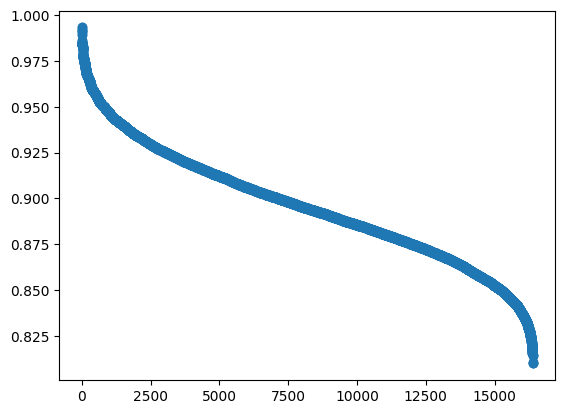

PyObject <matplotlib.collections.PathCollection object at 0x17d50fc10>

In [8]:
# We can plot all the fidelities...
scatter(1:length(singleParams),reverse(sort(map(x->x[2],singleParams))))

In [9]:
## The global probability vector is now the hadamard transform of the parameters
## And we project it down onto an actual probability simplex.

singlePs =  fwht_natural(vcat([1],map(x->x[2],singleParams)))
singlePps = projectSimplex(singlePs);

# Mutual Information plots


Used in Figure 2

- Generates the Mutual Information between each of the qubits.
- Then does this again for each of the boostrapped versions.

Draws them using a Hinton Plot, set out as per IBM layout

In [10]:
mutualPsSingle = [[mutualInformation(q,i,singlePps) for q in 1:14] for i in 1:14];


### We are now going to draw some things. 

A lot of the visualisation is quite particular to the layout of the 14 qubit machine.


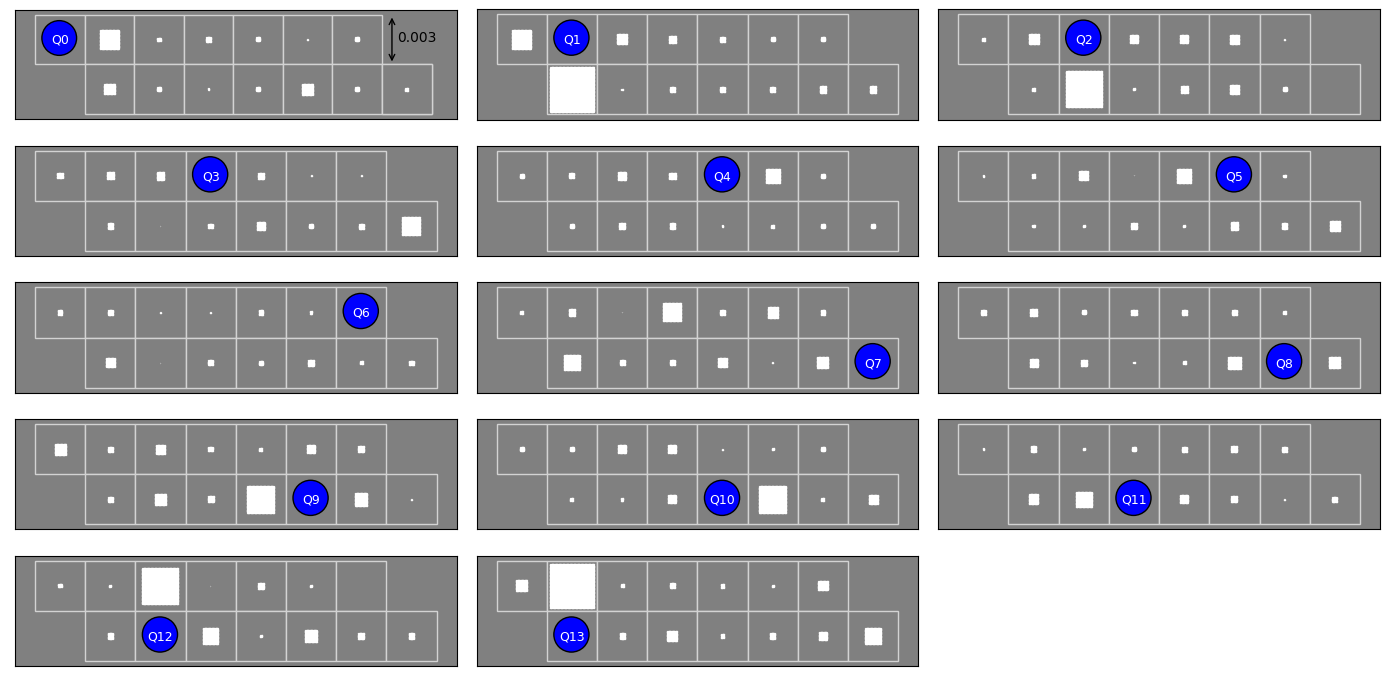

In [11]:
## Draw the hinton diagrams showing the mutual information between qubits
## translate_14Q_Locations just puts the qubits in the correct place for the Melbourne device.

fig = figure("Qubits Single Sigma",figsize=(14,7))
for i =1:14
    subplot(5,3,i)
    hinton(translate_14Q_Location(mutualPsSingle[i]',1),
        0.003,gca(),
        highlightNegative=true,fontsize=9,qubitPairs=[],addScale=i==1)
end
plt.tight_layout()


# Correlation Matrices



Used in Figure 2.

- corrmatSingle: the 14x14 correlation matrix using the projected global probability
- corrmatsSingle: the 14x14 correlation matrices for each of the bootstrapped probabilities.

In [12]:
corrmatSingle = correlationMatrix(singlePps);


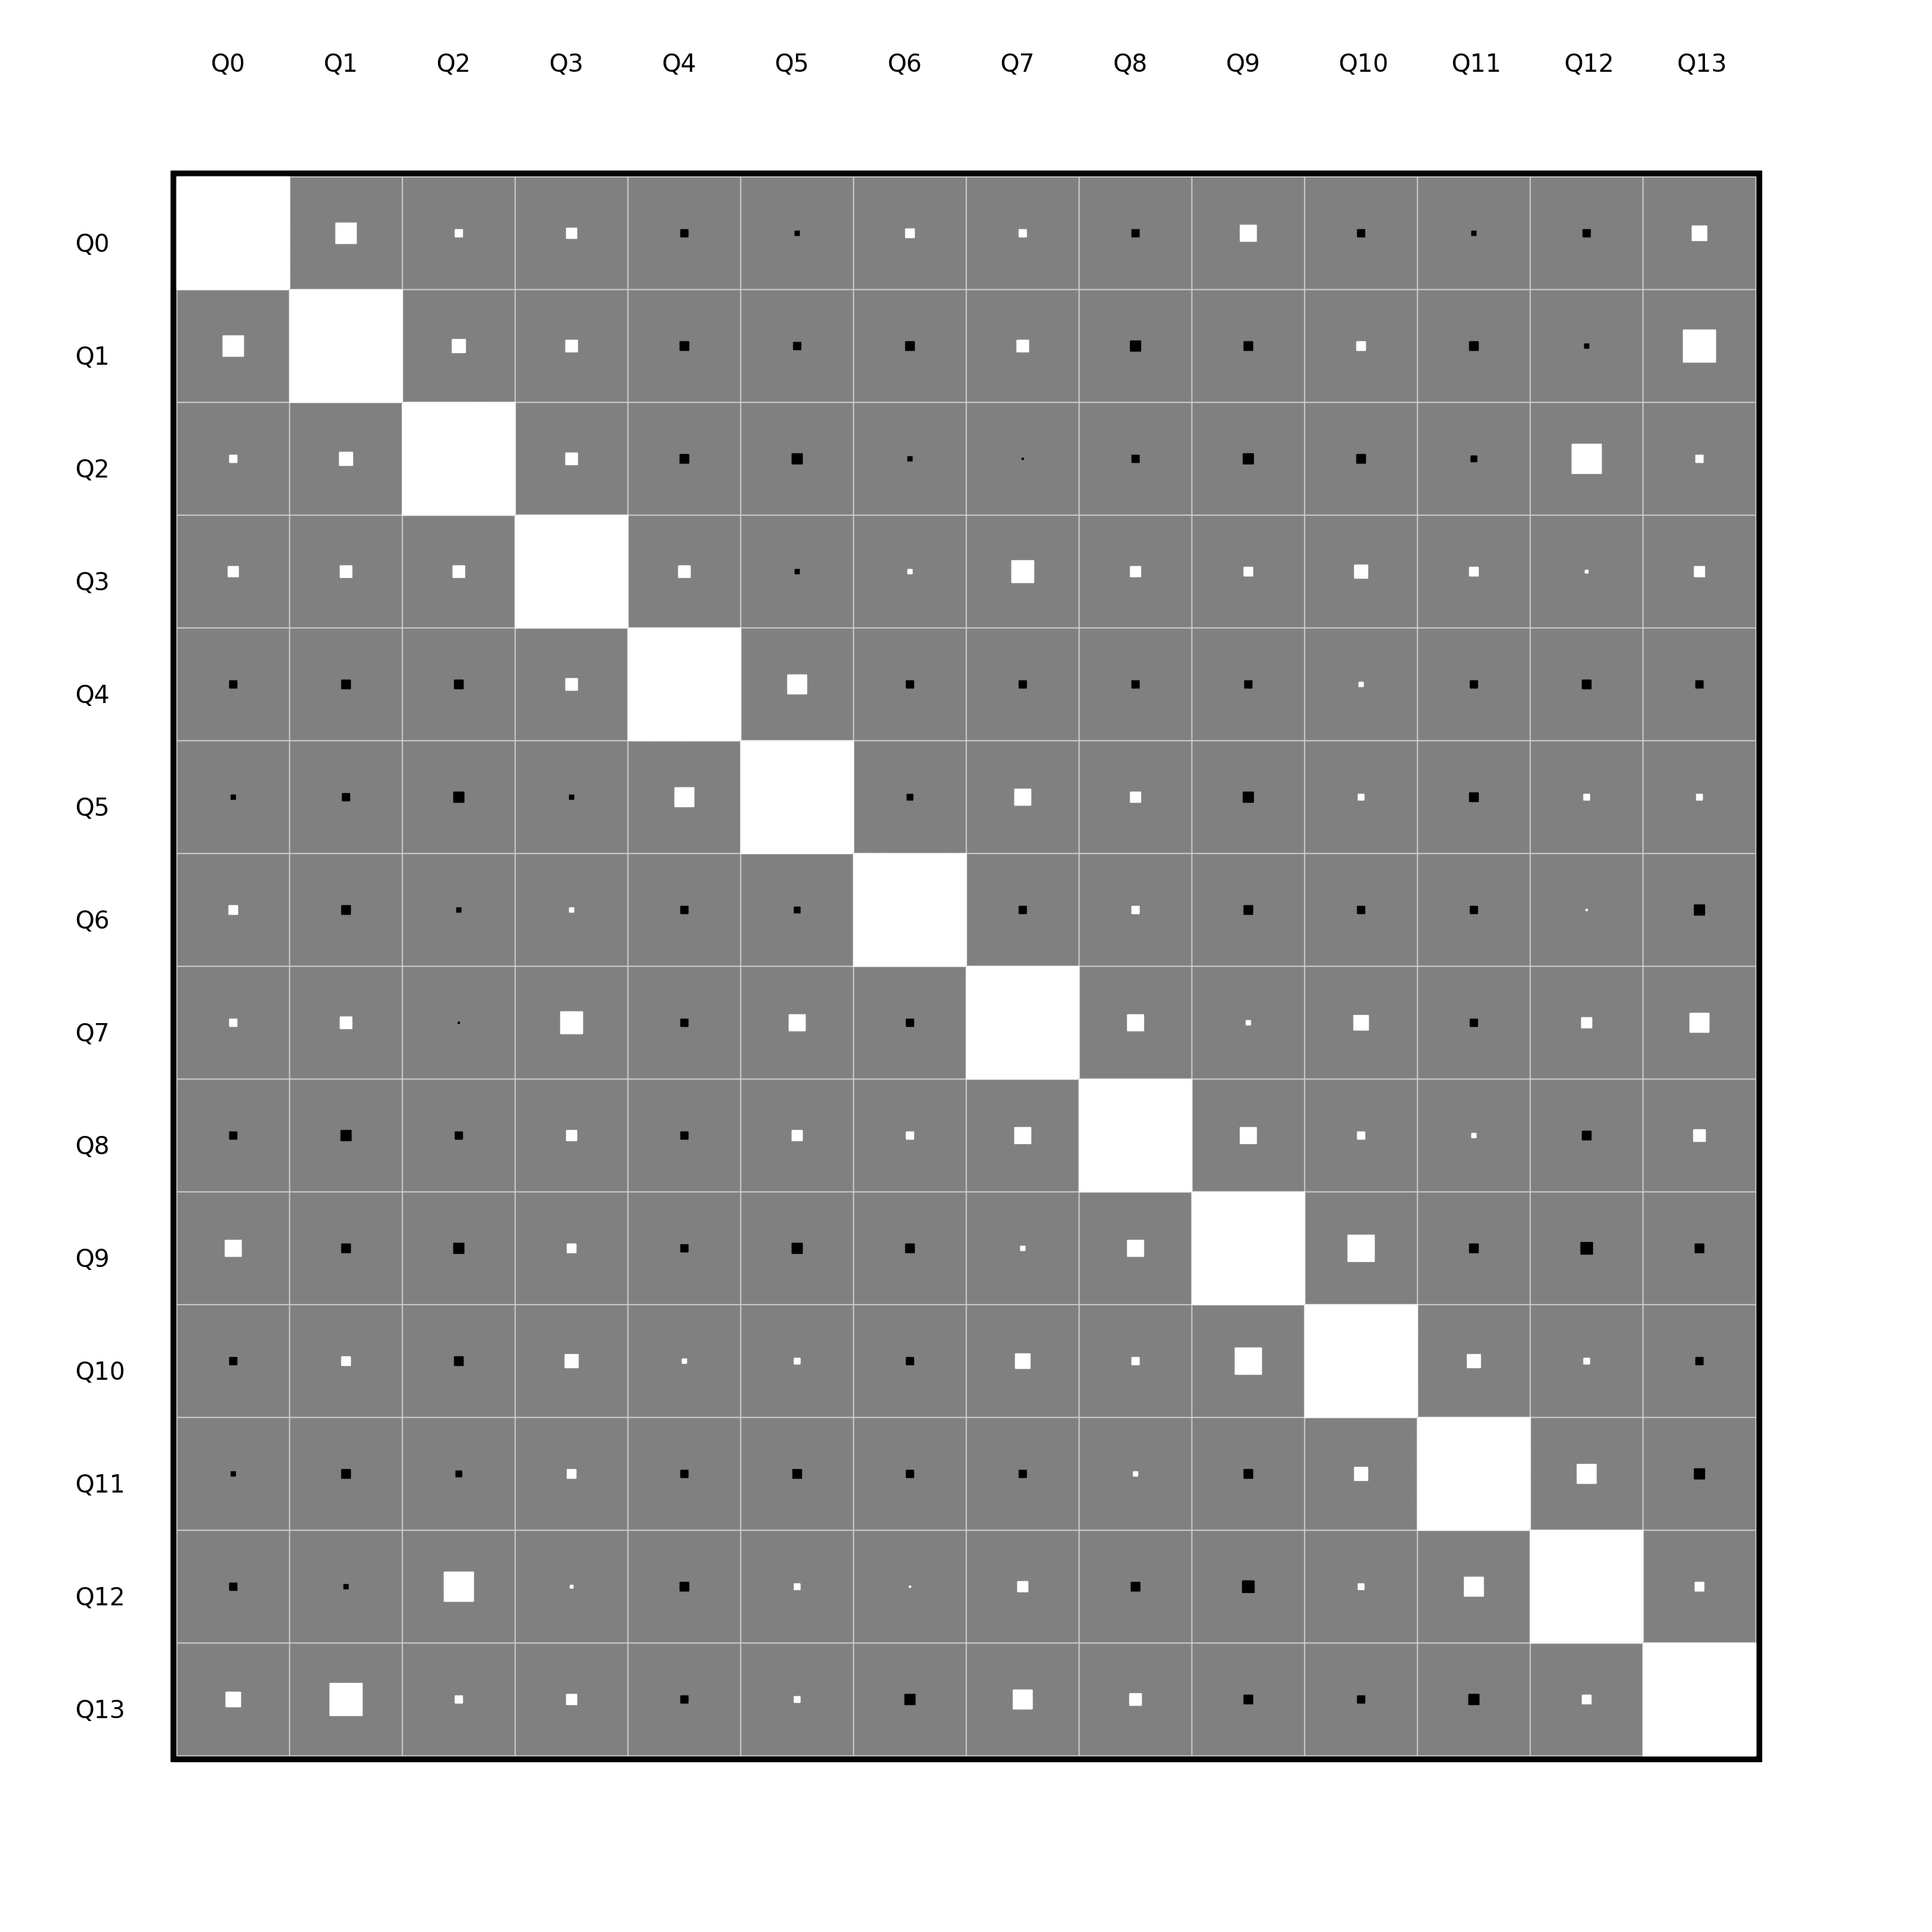

In [13]:
## This is a conventional hinton plot (area equals value, white = +ve, black = -ve)
# Large figure size gives us a crisp plot
fig = figure("Slightly larger",figsize=(34,34))

covhinton(corrmatSingle,1,gca(),
    addScale=false,addAxis=true,adjust=0.8,addOneAxis=true,showQubits=false,fontsize=24,stagger=false)



# Generate the GRF using global probabilities



This is based on the following 'ansatz'

![grf](./grf.png)

Where qubits have been renumbered to account for Julia prefering 1-indexing.

Used: 
- to construct JSD numbers in paper.
- Figure 2
- Figure 5 (supplement)

Creates:
- ϕ the joint probabilities for the Gibbs field.
- reconstructed, the reconstructed global probability distrubtion using ϕ
- corrmatSingleGibbs: The correlation matrix using the reconstructed probability distribution
- corrmatsSingleGibbs: The correlation matrix using the reconstructip p.d. for bootstrap data.



## Calculate the JSD for the ansatz

In [14]:
# This is our 'ansatz' based on the resonators of the IBM
# This is the 'simplest' way to use the software, but it requires the constraints in a particular way
# Here we look at the overlap so [[1,2,14],[2,14]] - would mean p(1,2|2,14)p(2,14) etc.

constraints = [[1,2,14],[2,14,13,3],[13,3,4,12],[4,12,5,11],[5,11,6,10],[6,10,7,9],[7,9,8]]

7-element Vector{Vector{Int64}}:
 [1, 2, 14]
 [2, 14, 13, 3]
 [13, 3, 4, 12]
 [4, 12, 5, 11]
 [5, 11, 6, 10]
 [6, 10, 7, 9]
 [7, 9, 8]

### We can look at the Relative Entropy between our $\tilde{\,p}_1$ and the reconstructed p

$D_{KL}(P||Q) = \sum\limits_{j}p_j\log\frac{p_j}{q_j}$

But *note* this is not defined if $q_j$ is zero when $p_j$ is non-zero, and it is not symmetric.

Instead use... 

### Jensen Shannon divergence 

Jensen Shannon divergence is symmetric, always valid and if you take the square root (Jensen Shannon Distance) it is a metric.

$\text{JSD}(P||Q) = \frac{1}{2}D(P||M) + \frac{1}{2}D(Q||M), M = \frac{1}{2}(P+Q)$

In [15]:
# A different (more general) way of expressing the constraints is, lists of conditionals
# So here we write out p(1|2,14)p(2,14|13,3)p(13,3|4,12)p(4,12|5,11)p(6,10|7,9)p(7,9,8)
# as

generalisedConstraints =[
                            [[1,],[2,14]],
                            [[2,14],[13,3]],
                            [[13,3],[4,12]],
                            [[4,12],[5,11]],
                            [[5,11],[6,10]],
                            [[6,10],[7,9]],
                            [[7,9,8],[]]]

# Which is the same as the one above.

7-element Vector{Vector{Vector{Any}}}:
 [[1], [2, 14]]
 [[2, 14], [13, 3]]
 [[13, 3], [4, 12]]
 [[4, 12], [5, 11]]
 [[5, 11], [6, 10]]
 [[6, 10], [7, 9]]
 [[7, 9, 8], []]

In [16]:
ϕold = gibbsRandomField(singlePps,constraints) 
reconstructed_old = [getGrainedP(ϕold,tomatch,[vcat(x[1],x[2]) for x in generalisedConstraints]) for tomatch =0:(2^14-1)]
sqrt(JSD(singlePps,reconstructed_old))

0.04164373289770054

In [17]:
# Then we can fill in the joint probabilities:
ϕ=gibbsRandomField(singlePps,generalisedConstraints) 
# Reconstruct the entire probability distribution using our markov field.
reconstructed = [getGrainedP(ϕ,tomatch,[vcat(x[1],x[2]) for x in generalisedConstraints]) for tomatch =0:(2^14-1)]
# And check we get the same JSD as with the earlier version
sqrt(JSD(singlePps,reconstructed))

0.04164373289770054

## Generate GRF correlations matrix (and all the bootstrapped ones.)

In [18]:

# This takes time.
corrmatSingleGibbs = correlationMatrix(reconstructed);


## Plot the GRF Correlation Matrix.

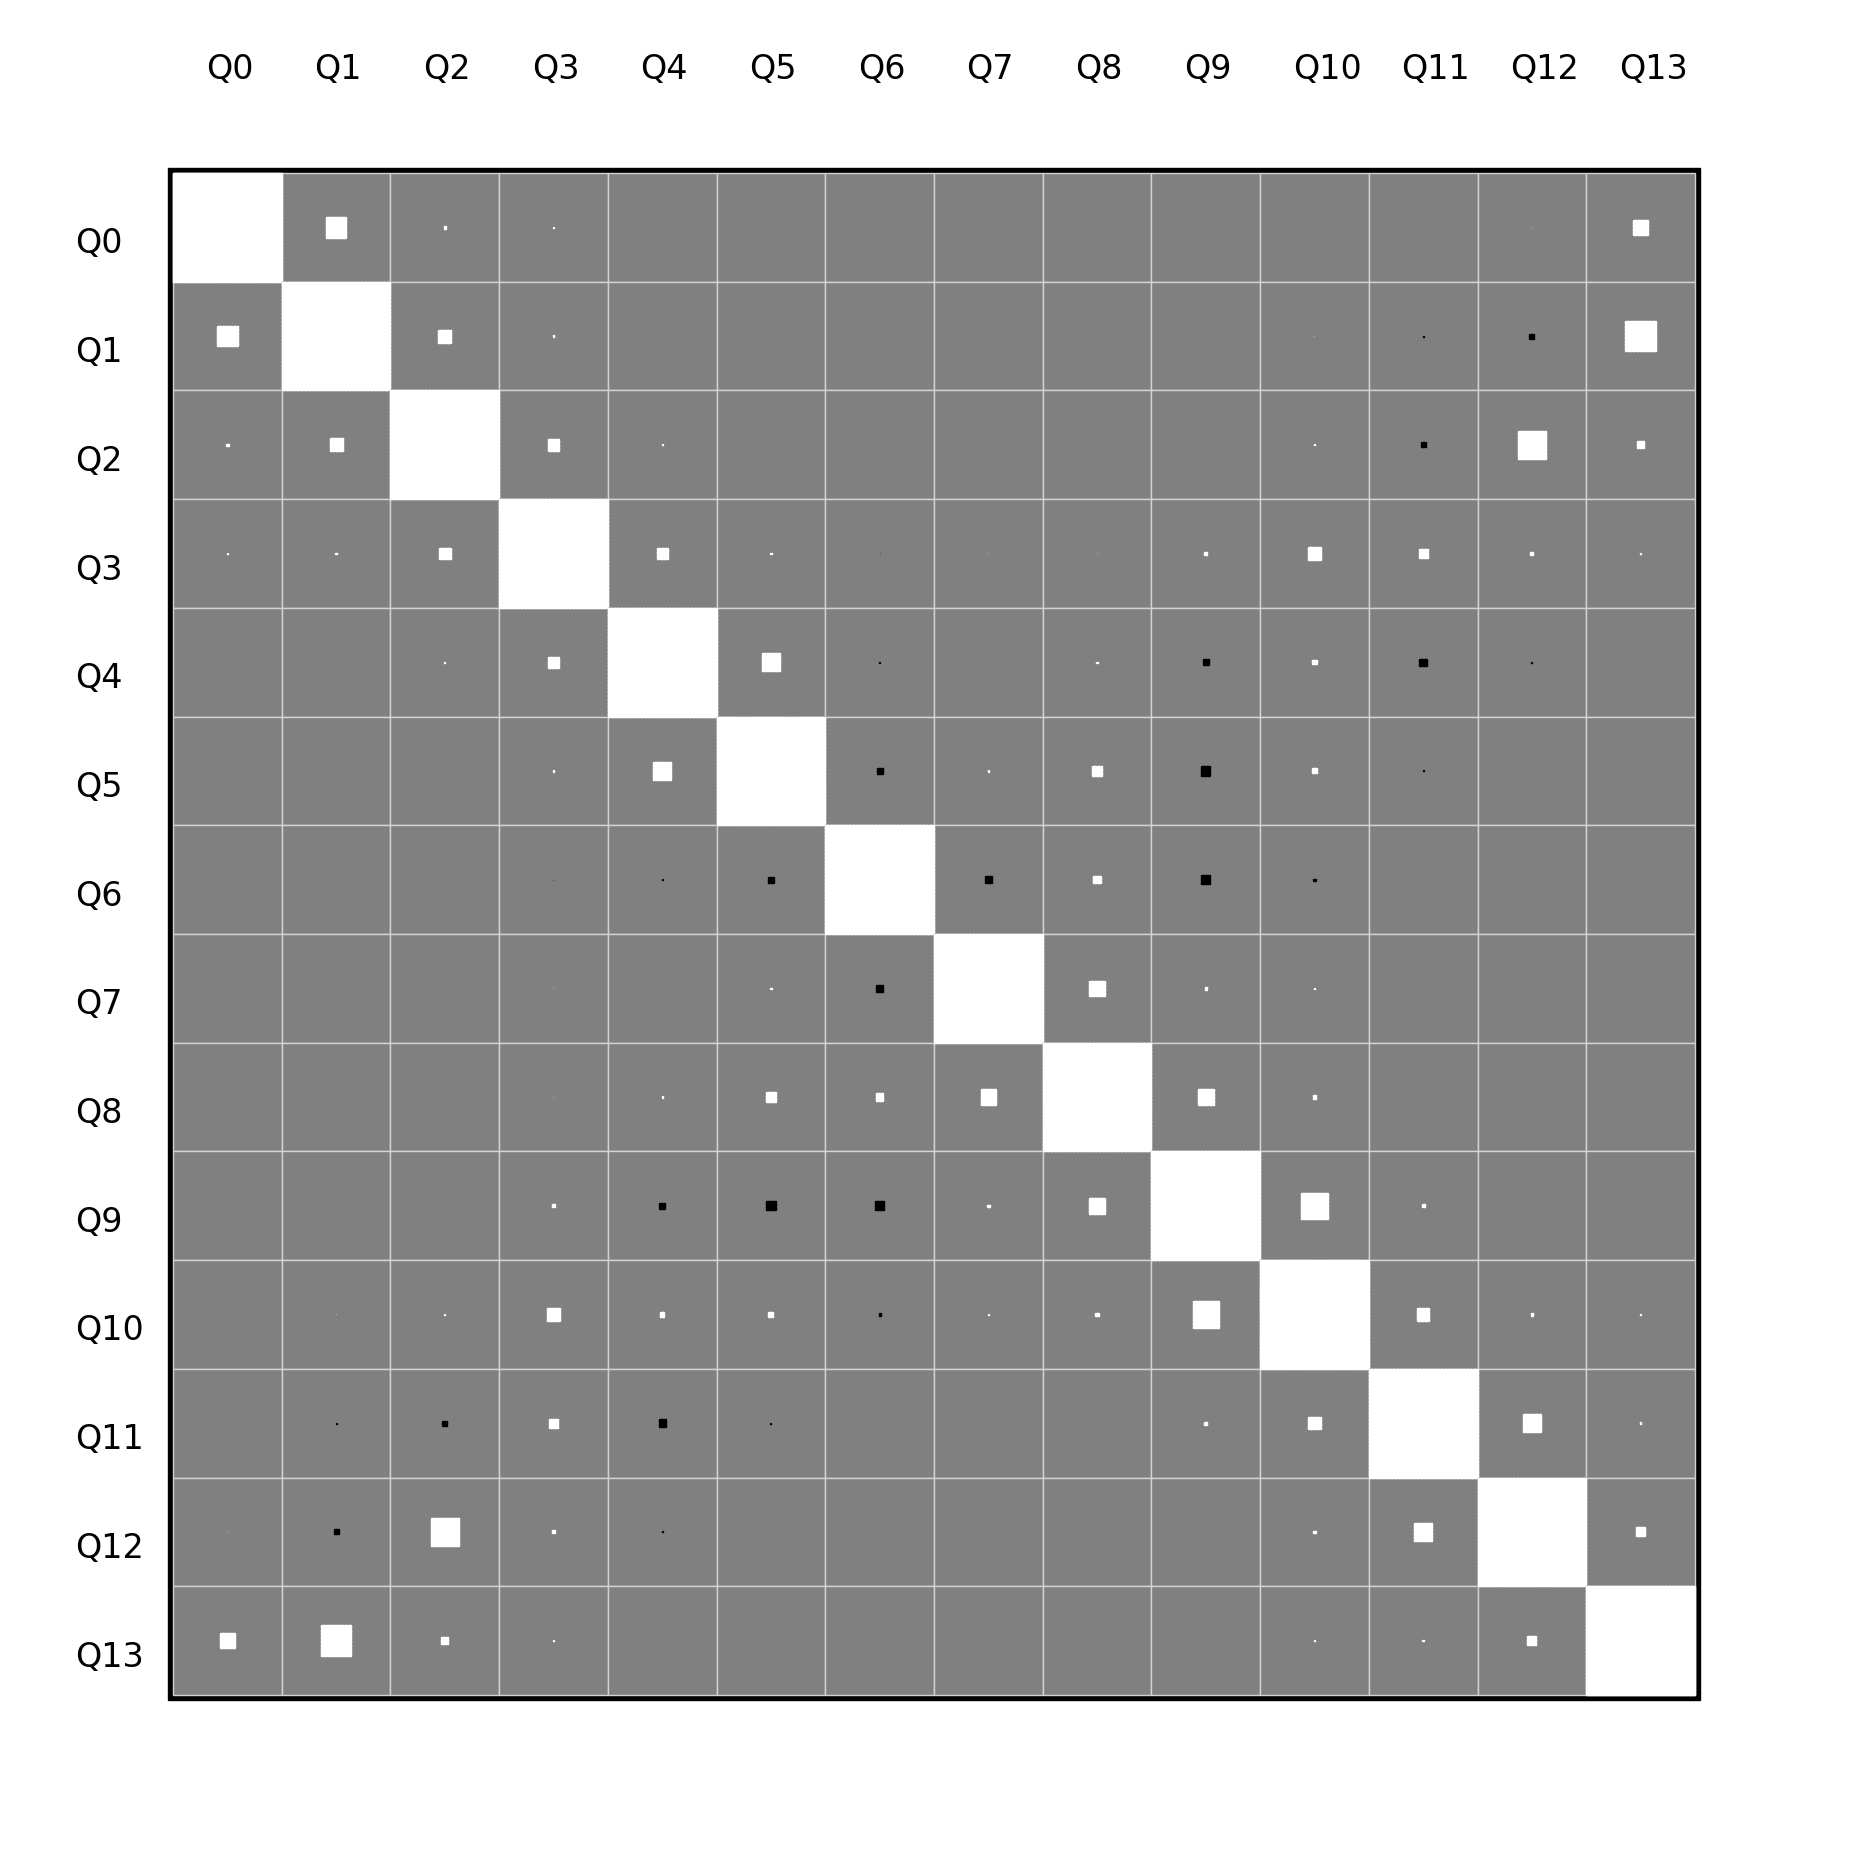

In [19]:
fig = figure("Slightly larger",figsize=(24,24))

fig = figure("Slightly larger",figsize=(12,12))

covhinton(corrmatSingleGibbs,1,gca(),
    addScale=false,addAxis=true,adjust=0.8,addOneAxis=true,showQubits=false,fontsize=24,stagger=false)


## Reproduce the combined Plot shown in Figure 2

In [20]:
# To fully recreate the correlation matrix in Figure 2, we need to combine our previous charts.

corrmatCombined = copy(corrmatSingle)
for j = 2:14
    for i = 1:j-1
        corrmatCombined[i,j] = corrmatSingleGibbs[i,j]
    end
end

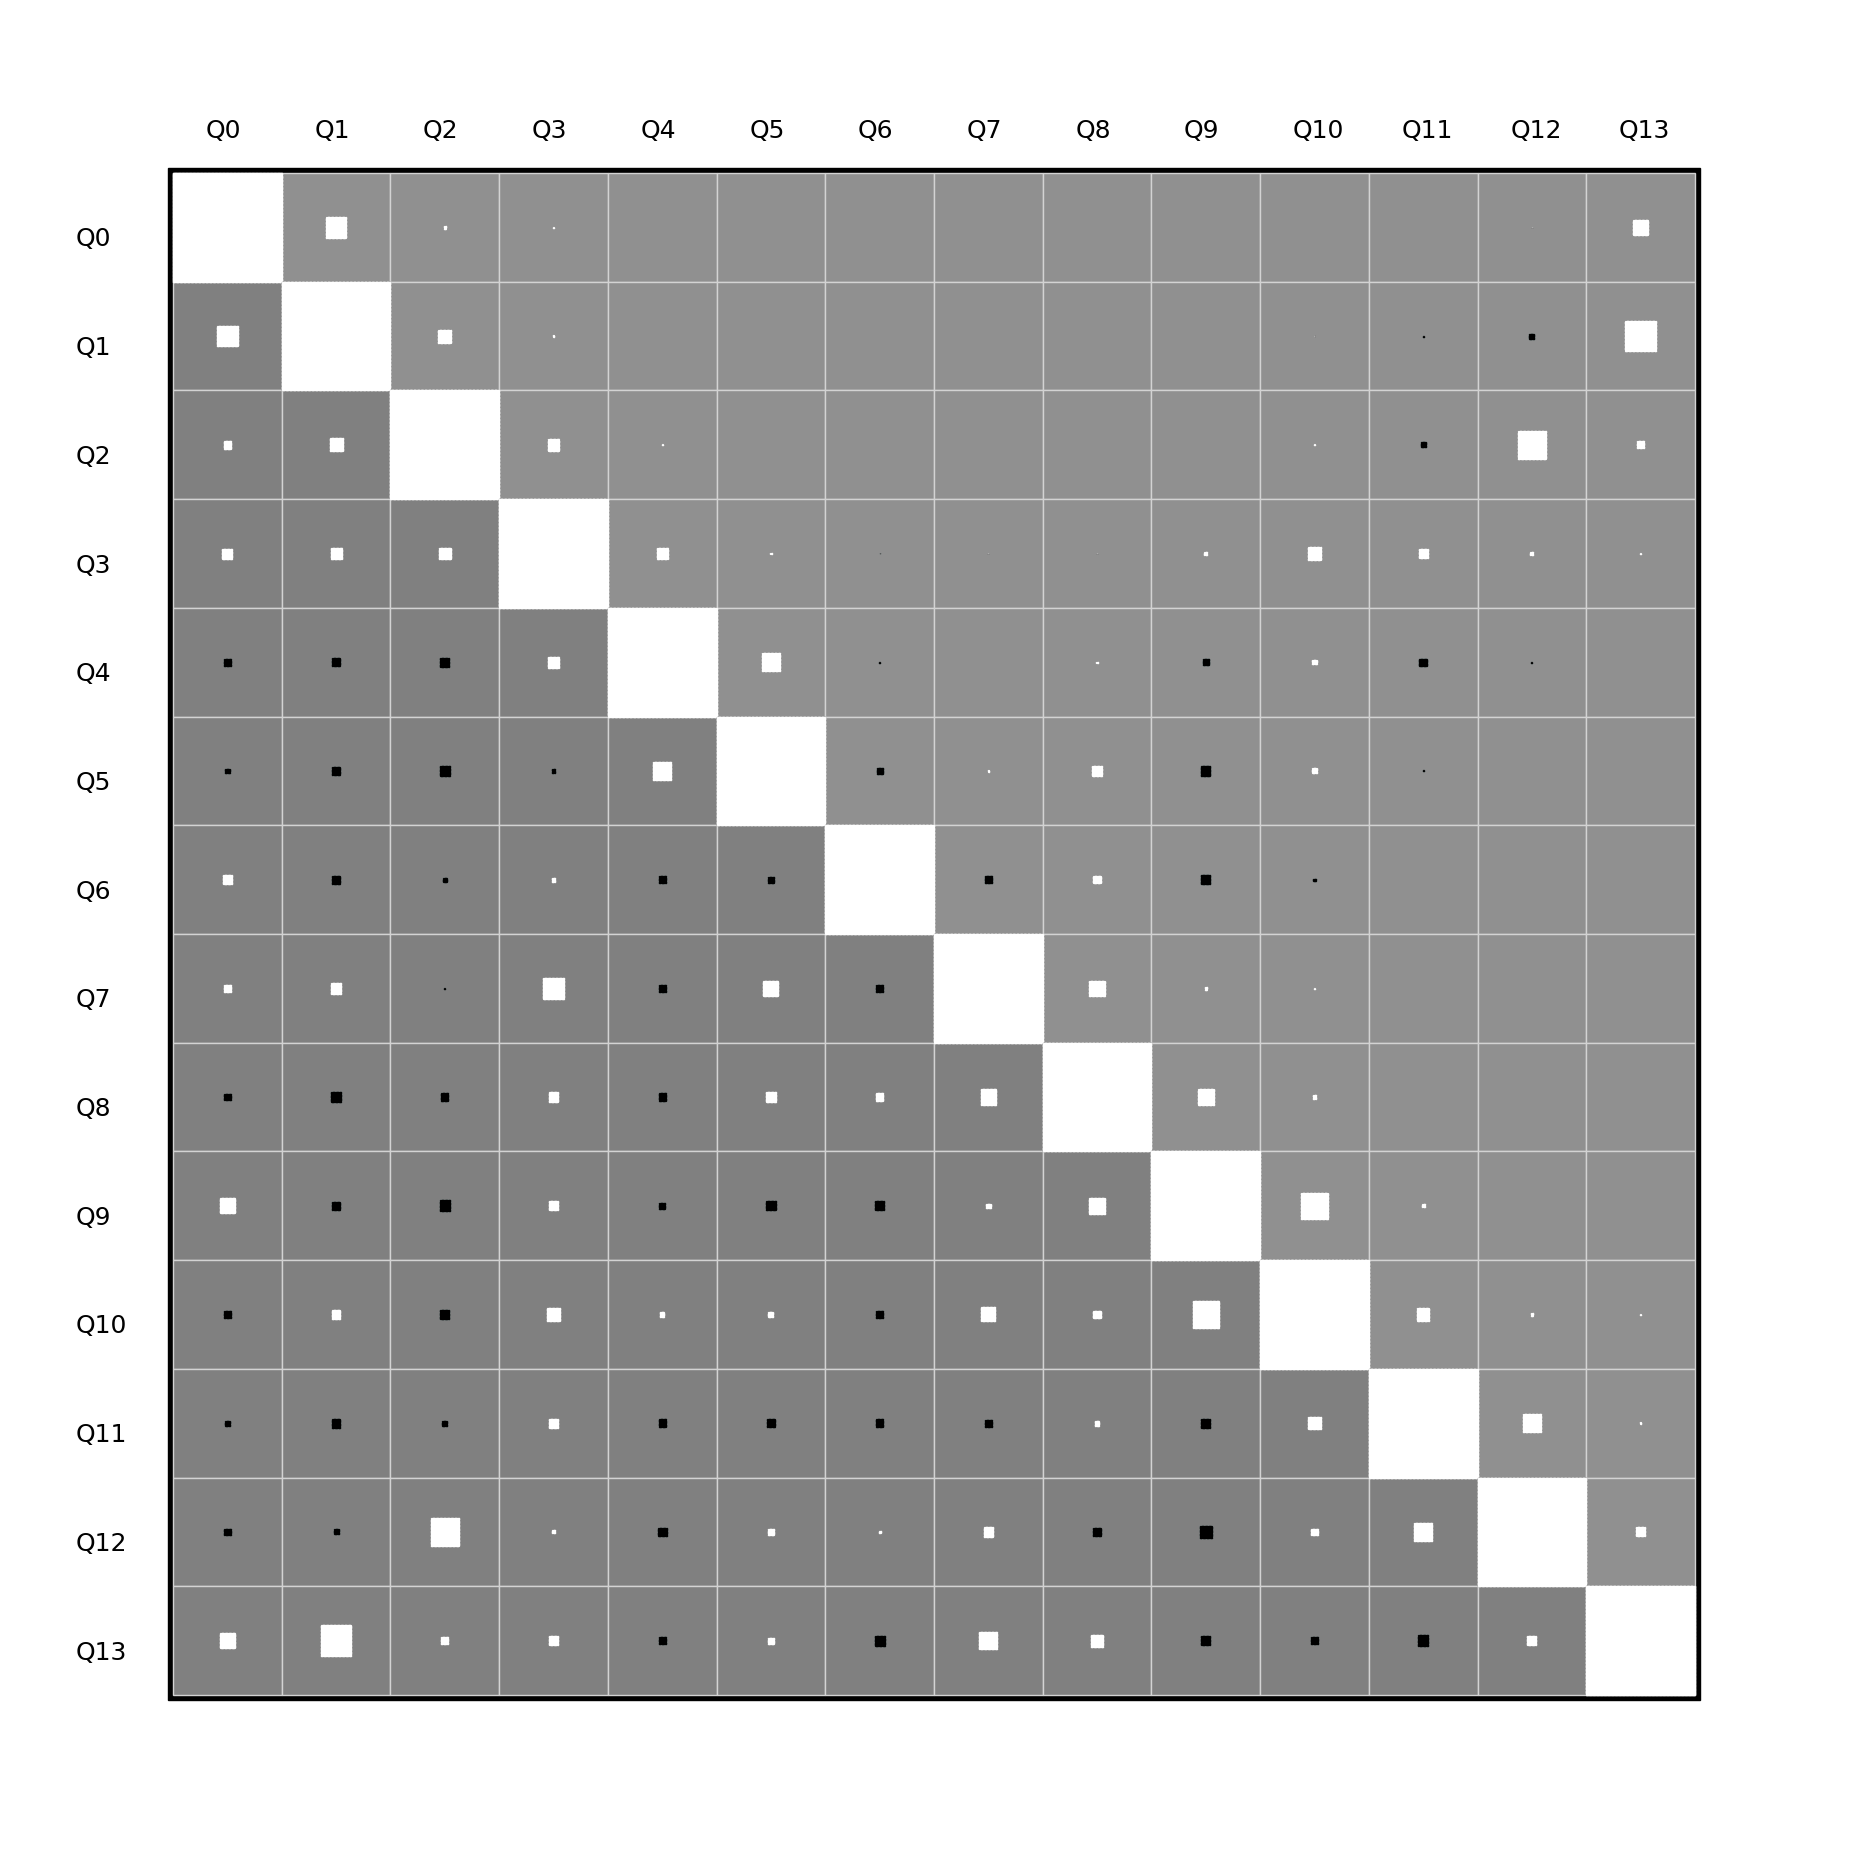

In [21]:
fig = figure("Slightly larger",figsize=(24,24))
covhinton(corrmatCombined,1,gca(),
    addScale=false,
    addAxis=true,
    adjust=0.8,
    voffset=0.6,
    addOneAxis=true,
    showQubits=false,
    fontsize=18,
    stagger=false,
    altColor="#909090")



### Seeing how good the fidelities are


In [22]:

for i = 1:14
    print("$i -> $(singleParams[2^(i-1)][2])\n")
end

1 -> 0.9932324762291926
2 -> 0.9587057895066153
3 -> 0.9764096301614209
4 -> 0.9914470144273135
5 -> 0.9915582760133966
6 -> 0.9888915877220733
7 -> 0.9923471657027396
8 -> 0.993221207449483
9 -> 0.9898335914575224
10 -> 0.9808116162260825
11 -> 0.9920567042661472
12 -> 0.9906046985830411
13 -> 0.9735830406430029
14 -> 0.9658785268210975


# Reconstruct the GRF by maginalising at the data results level


We take shortcut by omitting an easily writeable (if tedious) step. 

Recall we have our raw observation matrices for each of the RB lengths, stored in $2^{14}$ vectors, because this is quite a well behaved machine they are sparse. However if we really had $n$=50 qubits, then we couldn't store these vectors. We don't need to store it, read on:

The algorithm I'm going to call works as follows:

It uses the constraints for the Gibbs Random Field, to work out that what I need is, say, the joint probability distribution of qubits 1,2,3 and 4. To get them it marginalises the raw data probabilities (so the $2^4$ set of numbers that represent the measurement outcome probabilities for these qubits, irrespective of the outcomes of the others). Now I lazily just pass in the $2^{14}$ vector and then call marginalise on it.

If I couldn't do that (n=50), I would have to read in each of the measurement strings, extract the relevant qubits from each bitstring and then create the $2^4$ set of probabilities. That is an easy (if fidly) programming exercise that just requires you storing a large number of 50 bit bitstring (for n=50). To make it as efficient as possible might be fun, but I'm not going to do it until I need to.

So assuming we marginalised our input data we then then work out the joint probabilities we want.

It goes like this:

1) marginalised the input data. 
2) transform with Hadamard.
3) fit, extract the fit parameter.
4) transform back and project (just like before) 

except we are now dealing with really small probabilitiy vectors (2^3, 2^4 etc). The actual size of the probability vectors will depend on the bounded degree of the GRF in question.

This allows us to fill in the values of our gibbs field approximation. And efficiently we are done.

I'll show the few lines of code needed.

The essence of this is to realise that the hadamard **and fitting procedure** commute with marginalisation. This is not immediately obvious, but it means we get **exactly** the same marginalised vector at the end. The only thing that doesn't commute is the projection onto a probabilitiy simplex. That is future work.

Hopefully below explains what I mean here and what we are about to do.

<img src="./hadamard.gif/">

## Reconstruct from marginalising data

- Checks JSD

In [23]:
gibbsϕ2 = marginaliseFromRawData(splitMatrixS,constraints,singleLengths)

7-element Vector{Vector{Float64}}:
 [0.996905633730862, 0.003094366269137937, 0.9871215784906647, 0.012878421509335245, 0.9942102490653986, 0.005789750934601392, 0.9651459771606561, 0.034854022839343864]
 [0.9650034423996187, 0.01835488895262135, 0.014873131118649397, 0.001768537529110604, 0.9613290439478033, 0.006658028370880494, 0.016120058327576386, 0.01589286935373979, 0.936919407189095, 0.0396429777856237, 0.006860468057589948, 0.016577146967691338, 0.7790250645405603, 0.068478859113908, 0.107232776113975, 0.04526330023155672]
 [0.9764193865124324, 0.011629238273707475, 0.01072478728433894, 0.001226587929521112, 0.9632823056863187, 0.01828767252899094, 0.013571820672824536, 0.004858201111865769, 0.9315536641288094, 0.06844633587119062, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
 [0.9910095907110524, 0.004175377401972098, 0.004815031886975486, 0.0, 0.9726451713069119, 0.027354828693088144, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.844236190302653, 0.155763809697347, 0.0, 0.0]
 [0.9922626542056958, 0.0040

In [24]:
# For the sake of display!
for i in gibbsϕ2
    display(i)
end

8-element Vector{Float64}:
 0.996905633730862
 0.003094366269137937
 0.9871215784906647
 0.012878421509335245
 0.9942102490653986
 0.005789750934601392
 0.9651459771606561
 0.034854022839343864

16-element Vector{Float64}:
 0.9650034423996187
 0.01835488895262135
 0.014873131118649397
 0.001768537529110604
 0.9613290439478033
 0.006658028370880494
 0.016120058327576386
 0.01589286935373979
 0.936919407189095
 0.0396429777856237
 0.006860468057589948
 0.016577146967691338
 0.7790250645405603
 0.068478859113908
 0.107232776113975
 0.04526330023155672

16-element Vector{Float64}:
 0.9764193865124324
 0.011629238273707475
 0.01072478728433894
 0.001226587929521112
 0.9632823056863187
 0.01828767252899094
 0.013571820672824536
 0.004858201111865769
 0.9315536641288094
 0.06844633587119062
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0

16-element Vector{Float64}:
 0.9910095907110524
 0.004175377401972098
 0.004815031886975486
 0.0
 0.9726451713069119
 0.027354828693088144
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.844236190302653
 0.155763809697347
 0.0
 0.0

16-element Vector{Float64}:
 0.9922626542056958
 0.004094336335142865
 0.003643009459161241
 0.0
 0.9695675544359764
 0.030359475014977443
 4.5654899623218165e-5
 2.7315649423167852e-5
 0.9734014623994193
 0.0
 0.026598537600580813
 0.0
 0.0
 0.0
 0.0
 0.0

16-element Vector{Float64}:
 0.9845556715752929
 0.005584496208163005
 0.009859832216544023
 0.0
 0.9688785965659716
 0.031121403434028347
 0.0
 0.0
 0.9734002086173513
 0.005272338185055682
 0.02132745319759306
 0.0
 1.0
 0.0
 0.0
 0.0

8-element Vector{Float64}:
 0.9878530490208761
 0.0038144567046507066
 0.00489980549443772
 2.762647437813681e-5
 0.0032610269102182343
 0.0
 0.00014403539543908495
 0.0

In [25]:
# Lets check this out (because we can) blow it up to the full probability distribution
reconstructedPps2 = [getGrainedP(gibbsϕ2,tomatch,constraints) for tomatch=0:(2^14-1)]
@assert(isapprox(sum(reconstructedPps2),1))

In [26]:
# This is what we had with the 'full' GRF reconstruction
sqrt(JSD(singlePps,reconstructed))

0.04164373289770054

In [27]:
# This is what we had with the 'efficient' GRF construciton
sqrt(JSD(singlePps,reconstructedPps2))

0.04655990359772818

## Create Correlation matrices

In [28]:
# Then the GRF from the marginalised observations
corrmatSingleGibbsM = correlationMatrix(reconstructedPps2);



In [29]:
# Moosh them together so one is in the top right and the other in the bottom left
corrmatCombined = copy(corrmatSingleGibbs)
for j = 2:14
    for i = 1:j-1
        corrmatCombined[i,j] = corrmatSingleGibbsM[i,j]
    end
end
    

## Generate a figure, which should have been in the supplement of our paper, but...

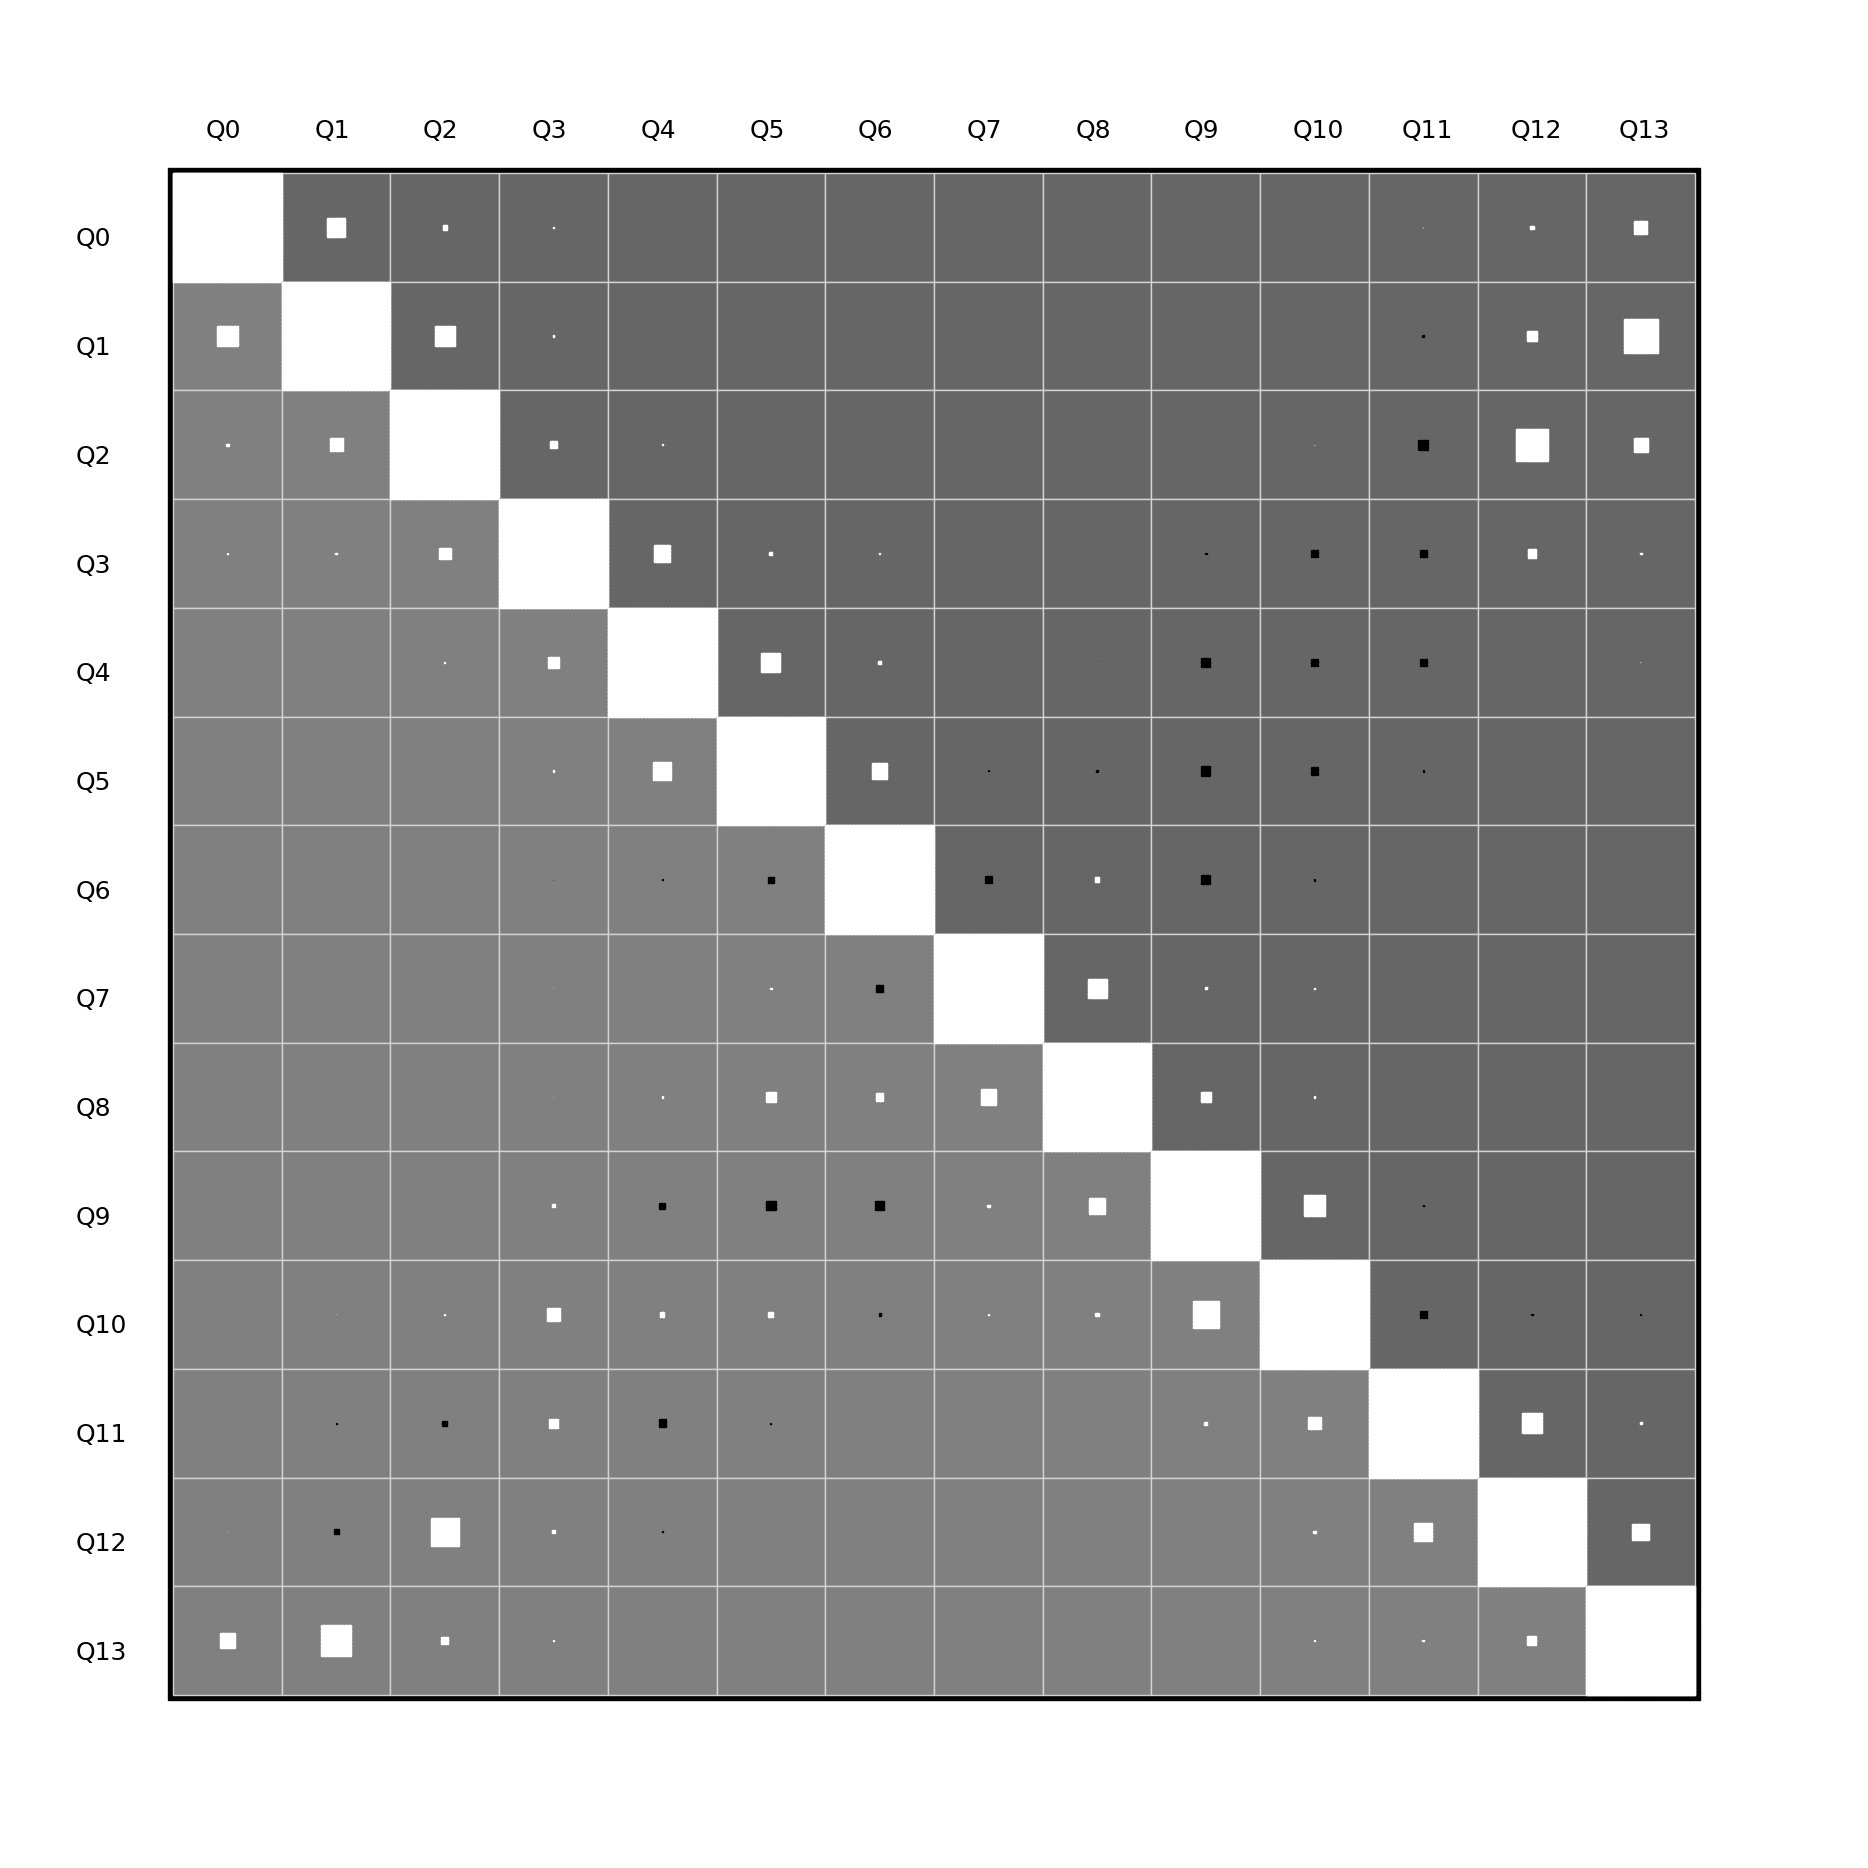

In [30]:
fig = figure("Slightly larger",figsize=(24,24))
covhinton(corrmatCombined,1,gca(),
    addScale=false,
    addAxis=true,
    adjust=0.8,
    voffset=0.6,
    addOneAxis=true,
    showQubits=false,
    fontsize=18,
    stagger=false,
    altColor="#666666")



# Reconstruct the Covariance matrix using averaged Pauli error rates.



Single protocol version of Figure 4 (Supplement)

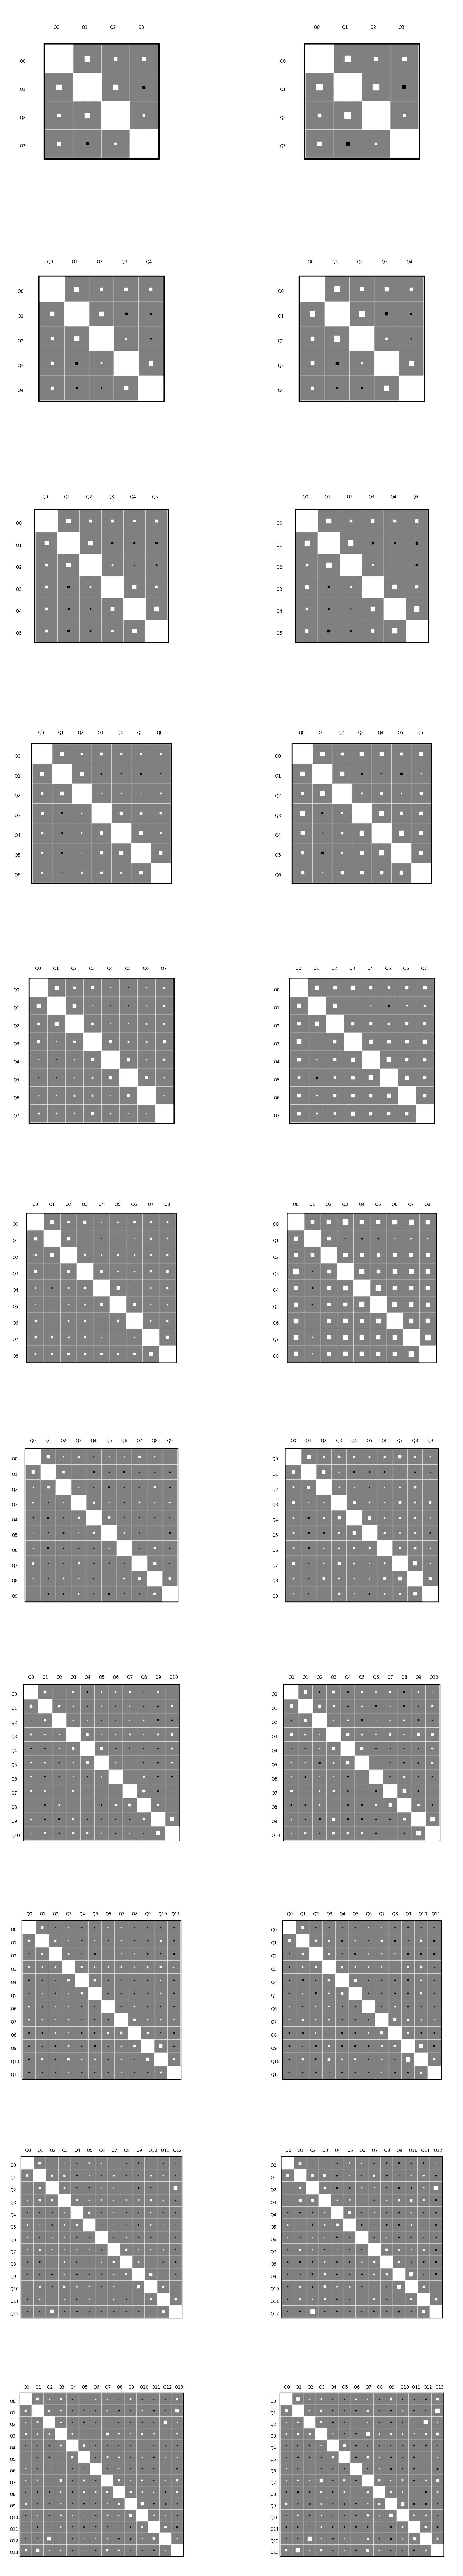

In [31]:
# These matrices are derived in the Supplement of the paper.

M = [1 0;0 1;0 1;0 1]
MI = [1 0 0 0;0 1 1 1]
actualN = MI*(0.25*[1 1;1 -1]⊗[1 1;1 -1])*M

fig = figure("Slightly larger",figsize=(24,130))

# Check for various sizes of data.
for q = 4:14

sM1_4=[marginalise(1:q,m) for m in splitMatrixS];   
newEigs = vcat([1],map(x->x[2],fitTheFidelities(singleLengths,sM1_4)[1]))
# Get the 'corrected' eigenvalues.
newEigs = ifwht_natural(projectSimplex(fwht_natural(newEigs)))

# p4 represents the 'Observed error rates'
p4 =  projectSimplex(fwht_natural(newEigs))
# xp4 re
xp4 = projectSimplex(foldl(⊗,[actualN for _=1:q])*newEigs)

corrmat1= correlationMatrix(p4);
corrmat2= correlationMatrix(xp4);



subplot(11,2,(q-4)*2+1)
ax=gca()
covhinton(corrmat1,1,ax,
            addAxis=true,adjust=0.8,addOneAxis=true,
            stagger=false,voffset=0.4)

subplot(11,2,(q-4)*2+2)
ax=gca()
covhinton(corrmat2,1,ax,
            addAxis=true,adjust=0.8,addOneAxis=true,
            stagger=false,voffset=0.4)
end
#fig 